In [1]:
import os,sys
from utils import *
from sklearn.model_selection import train_test_split
from gensim.models.word2vec import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
import numpy as np
import pandas as pd
from collections import Counter
from tqdm import tqdm
import jieba
from torch import nn
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from sklearn.metrics import *

os.chdir(sys.path[0])

In [2]:
data_path = r'..\data\online_shopping_10_cats\online_shopping_10_cats.csv'
pd_all = pd.read_csv(data_path)

In [3]:
print('评论数目（总体）：%d' % pd_all.shape[0])
print('评论数目（正向）：%d' % pd_all[pd_all.label==1].shape[0])
print('评论数目（负向）：%d' % pd_all[pd_all.label==0].shape[0])

评论数目（总体）：62774
评论数目（正向）：31728
评论数目（负向）：31046


In [4]:
pd_all.head()

,cat,label,review
0,书籍,1,﻿做父母一定要有刘墉这样的心态，不断地学习，不断地进步，不断地给自己补充新鲜血液，让自己保持...
1,书籍,1,作者真有英国人严谨的风格，提出观点、进行论述论证，尽管本人对物理学了解不深，但是仍然能感受到...
2,书籍,1,作者长篇大论借用详细报告数据处理工作和计算结果支持其新观点。为什么荷兰曾经县有欧洲最高的生产...
3,书籍,1,作者在战几时之前用了＂拥抱＂令人叫绝．日本如果没有战败，就有会有美军的占领，没胡官僚主义的延...
4,书籍,1,作者在少年时即喜阅读，能看出他精读了无数经典，因而他有一个庞大的内心世界。他的作品最难能可贵...


In [5]:
def load_data(file_path,sample_ratio=1):
    pd_all = pd.read_csv(file_path)
    total_length = pd_all.shape[0]
    labels = list(pd_all.loc[:,'label'].astype(str))
    reviews = list(pd_all.loc[:,'review'].astype(str))
    ratio_num = int(total_length * sample_ratio)
    return reviews[0:ratio_num],labels[0:ratio_num]

In [6]:
reviews,labels = load_data(data_path)

In [7]:
print(reviews[0])

做父母一定要有刘墉这样的心态，不断地学习，不断地进步，不断地给自己补充新鲜血液，让自己保持一颗年轻的心。我想，这是他能很好的和孩子沟通的一个重要因素。读刘墉的文章，总能让我看到一个快乐的平易近人的父亲，他始终站在和孩子同样的高度，给孩子创造着一个充满爱和自由的生活环境。很喜欢刘墉在字里行间流露出的做父母的那种小狡黠，让人总是忍俊不禁，父母和子女之间有时候也是一种战斗，武力争斗过于低级了，智力较量才更有趣味。所以，做父母的得加把劲了，老思想老观念注定会一败涂地，生命不息，学习不止。家庭教育，真的是乐在其中。


In [8]:
vocabs = []
for item in tqdm(reviews):
    vocabs.extend(jieba.cut(item))

  0%|          | 0/62774 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\HZH\AppData\Local\Temp\jieba.cache
Loading model cost 0.569 seconds.
Prefix dict has been built successfully.
100%|██████████| 62774/62774 [00:16<00:00, 3795.71it/s]


In [9]:
len(vocabs)

2359953

In [10]:
set_vocabs = list(set(vocabs))
len(set_vocabs)

68495

In [11]:
sentences = []
for item in tqdm(reviews):
    sentences.append(list(jieba.cut(item)))

100%|██████████| 62774/62774 [00:15<00:00, 3928.03it/s]


In [12]:
vocabs_len = []
for item in tqdm(reviews):
    vocabs_len.append(len(list(jieba.cut(item))))   # 分词后的长度
pd_all['review_len'] = vocabs_len

100%|██████████| 62774/62774 [00:15<00:00, 3982.36it/s]


In [13]:
pd_all['review_len'].describe(percentiles=[.5,.95])

count    62774.000000
mean        37.594434
std         49.913748
min          1.000000
50%         23.000000
95%        117.000000
max       1795.000000
Name: review_len, dtype: float64

In [12]:
### 只保留出现频率大于15的词,偏僻词等略过,如果计算资源充足的，可以自行调整频率大小
Freq = 15
word_freq_file = '..\data\online_shopping_10_cats\word_freq.txt'
with open(word_freq_file,"w",encoding='utf-8',) as fout:
    for word,freq in dict(Counter(vocabs)).items():
        if freq>Freq:
            fout.write(word+'\n')

In [13]:
with open(word_freq_file, encoding='utf-8') as fin:
    vocab = [i.strip() for i in fin]
vocab=set(vocab)
word2idx = {i:index for index, i in enumerate(vocab)}
idx2word = {index:i for index, i in enumerate(vocab)}
vocab_size = len(vocab)
len(vocab)

7470

In [14]:
pad_id = word2idx['的']

In [15]:
sequence_length = 110
#对输入数据进行预处理,主要是对句子用索引表示且对句子进行截断与padding，将填充使用”的“来。
def tokenizer(pd_all,pad_id):   # 分词
    inputs = []
    sentence_char = [list(jieba.cut(item)) for item in pd_all["review"].astype(str)]    
    # 将输入文本进行padding
    for index,item in enumerate(sentence_char):
        ### 若查找不存在，则返回第二个参数设置的默认值
        temp=[word2idx.get(item_item,pad_id) for item_item in item]#表示如果词表中没有这个稀有词，无法获得，那么就默认返回pad_id。
        if(len(item)<sequence_length):
            for _ in range(sequence_length-len(item)):
                temp.append(pad_id)
        else:
            temp = temp[:sequence_length]
        inputs.append(temp)
    return inputs

data_input = tokenizer(pd_all,pad_id)

In [16]:
### 创建一个关于sentences的迭代对象，返回的是一个生成器
class genrate_sentence(object):
    def __init__(self,sentences):
        self.sentences = sentences

    def __iter__(self):
        for item in self.sentences:
            yield item

In [17]:
total_num = len(sentences)

In [18]:
### 利用gensim创建word2vec模型
def create_word2vec_model(sentences,total_examples=total_num,vector_size=100,window=5,min_count=15):
    model = Word2Vec(sentences,vector_size=vector_size,window=window,min_count=min_count)
    ### 训练模型
    model.train(sentences,total_examples=total_num,epochs=10)
    ### 保存模型
    model.save('..\data\online_shopping_10_cats\word2vec_model.pkl')
    return model

In [19]:
word2vec_model = create_word2vec_model(genrate_sentence(sentences))

In [20]:
### 保存词向量
word_vector = word2vec_model.wv
word_vector.save('..\data\online_shopping_10_cats\word_vector.pkl')

In [21]:
w2v = KeyedVectors.load('..\data\online_shopping_10_cats\word_vector.pkl')

In [22]:
w2v.key_to_index

{'，': 0,
 '的': 1,
 '。': 2,
 '了': 3,
 '！': 4,
 ' ': 5,
 '很': 6,
 '是': 7,
 '我': 8,
 '也': 9,
 '好': 10,
 '不': 11,
 ',': 12,
 '都': 13,
 '就': 14,
 '买': 15,
 '不错': 16,
 '还': 17,
 '在': 18,
 '有': 19,
 '没有': 20,
 '酒店': 21,
 '用': 22,
 '.': 23,
 '京东': 24,
 '和': 25,
 '说': 26,
 '房间': 27,
 '给': 28,
 '可以': 29,
 '、': 30,
 '这': 31,
 '就是': 32,
 '到': 33,
 '非常': 34,
 '一个': 35,
 '感觉': 36,
 '还是': 37,
 '？': 38,
 '没': 39,
 '这个': 40,
 '服务': 41,
 '质量': 42,
 '人': 43,
 '比较': 44,
 '上': 45,
 '苹果': 46,
 '要': 47,
 '看': 48,
 '去': 49,
 '喜欢': 50,
 '东西': 51,
 '太': 52,
 '不是': 53,
 '又': 54,
 '小': 55,
 '但': 56,
 '我们': 57,
 '大': 58,
 '价格': 59,
 '让': 60,
 '什么': 61,
 '但是': 62,
 '吧': 63,
 '你': 64,
 '差': 65,
 '住': 66,
 '而且': 67,
 '多': 68,
 '个': 69,
 '…': 70,
 '知道': 71,
 '自己': 72,
 '再': 73,
 '才': 74,
 '满意': 75,
 '会': 76,
 '啊': 77,
 '有点': 78,
 '：': 79,
 '对': 80,
 '比': 81,
 '不好': 82,
 '挺': 83,
 '问题': 84,
 '快递': 85,
 '收到': 86,
 '能': 87,
 '吃': 88,
 '手机': 89,
 '2': 90,
 '裤子': 91,
 '来': 92,
 '时候': 93,
 '一般': 94,
 '快': 95,
 '还有': 96,
 '一

In [23]:
### 利用word2idx、idx2word和w2v创建embedding矩阵，方便输入到模型中
def create_embedding_matrix(word2idx,w2v):
    embedding_matrix = np.zeros((len(word2idx),100))
    for word,index in word2idx.items():
        try:
            embedding_matrix[index,:] = w2v[word]
        except:
            embedding_matrix[index,:] = np.random.rand(100)
    return embedding_matrix

In [24]:
embedding_matrix = create_embedding_matrix(word2idx,w2v)

In [25]:
### 利用embedding_matrix创建embedding层
def create_embedding_layer(embedding_matrix):
    embedding = nn.Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1])
    embedding.weight = nn.Parameter(torch.tensor(embedding_matrix,dtype=torch.float32))
    return embedding

In [26]:
embedding = create_embedding_layer(embedding_matrix)

In [27]:
### 通过sklearn函数,创建训练集和验证集
def create_train_val_set(data_input,labels,val_size=0.1):
    train_input,val_input,train_labels,val_labels = train_test_split(data_input,labels,test_size=val_size)
    return train_input,val_input,train_labels,val_labels

In [28]:
### 生成训练集和验证集
train_input,val_input,train_labels,val_labels = create_train_val_set(data_input,labels,val_size=0.1)

In [29]:
### 创建训练和验证时用的dataset
class modeldataset(Dataset):
    def __init__(self,inputs,labels):
        self.inputs = inputs
        ### 将list中元素中为str的元素转换成int
        self.labels = [int(i) for i in labels]

    def __len__(self):
        return len(self.inputs)
        
    def __getitem__(self,index):
        # return self.inputs[index],self.labels[index]
        ### 将labels的list中元素中为str的元素转换成int
        ### 将labels标签，根据0和1的值，设置成二分类
        # if(self.labels[index]==0):
        #     labels = np.array([1,0])
        # else:
        #     labels = np.array([0,1])
        return torch.tensor(self.inputs[index],dtype=torch.long),torch.tensor(self.labels[index],dtype=torch.float32)

In [30]:
train_dataset = modeldataset(train_input,train_labels)
val_dataset = modeldataset(val_input,val_labels)

In [31]:
### 创建AttBiLSTM模型,结合上面的embedding层
class AttBiLSTM(nn.Module):
    def __init__(self,embedding_layer,vocab_size,embedding_dim,hidden_dim,num_classes=1,dropout=0.5):
        super(AttBiLSTM,self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes

        self.embedding_layer = embedding_layer
        self.lstm = nn.LSTM(embedding_dim,self.hidden_dim,batch_first=True,bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(in_features=self.hidden_dim*2,out_features=self.num_classes)
    
    ### 创建自注意力层,lstm_output : [batch_size, n_step, n_hidden * num_directions(=2)], F matrix
    def attention(self,lstm_output, final_state):
        hidden = final_state.view(-1,self.hidden_dim*2,1) ### [batch_size, n_hidden * num_directions(=2), 1]
        att_weight = torch.bmm(lstm_output,hidden).squeeze(2) ### [batch_size, n_step]
        soft_att_weight = F.softmax(att_weight,dim=1) ### [batch_size, n_step]
        att_output = torch.bmm(lstm_output.transpose(1,2),soft_att_weight.unsqueeze(2)).squeeze(2) ### [batch_size, n_hidden * num_directions(=2)]
        return att_output,soft_att_weight.data ### [batch_size, n_hidden * num_directions(=2)]

    def forward(self,inputs):
        embedding_output = self.embedding_layer(inputs) ### [batch_size, n_step, embedding_dim]

        lstm_output,(final_hidden_state,final_cell_state) = self.lstm(embedding_output) ### [batch_size, n_step, n_hidden * num_directions(=2)]

        att_output,att_weight = self.attention(lstm_output,final_hidden_state) ### [batch_size, n_hidden * num_directions(=2)]

        dropout_output = self.dropout(att_output)
        ### [batch_size, n_hidden * num_directions(=2)] -> [batch_size, n_hidden * num_directions(=2)]
        fc_output = self.fc(dropout_output)
        ### [batch_size, n_hidden * num_directions(=2)] -> [batch_size, num_classes]


        return fc_output

In [32]:
embedding_dim = embedding_matrix.shape[1]
hidden_dim = 128

### 创建AttBiLSTM模型
model = AttBiLSTM(embedding_layer=embedding,vocab_size=embedding_matrix.shape[0],embedding_dim=embedding_matrix.shape[1],hidden_dim=hidden_dim)

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 模型和数据都导入到模型中
model.to(device)

AttBiLSTM(
  (embedding_layer): Embedding(7470, 100)
  (lstm): LSTM(100, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [36]:
lr = 0.001
weight_decay = 0.001
batch_size = 1024
epochs = 10
optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)
### 二分类损失函数
loss_func = nn.BCELoss()

train_loss_list = []
train_acc_list = []

### 最佳损失值和最佳准确率
best_loss = 1e10
best_acc = 0

### 创建训练数据
train_loader = DataLoader(dataset=train_dataset,batch_size=1024,shuffle=True)



for epoch in tqdm(range(epochs)):
    ### 训练
    train_loss = 0
    train_acc = 0
    y_true = []
    y_pred = []
    model.train()
    for step,(batch_x,batch_y) in enumerate(train_loader):
        batch_x = Variable(batch_x)
        batch_y = Variable(batch_y)
        ### 将数据导入到gpu中
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()

        outputs = model(batch_x)
        ### outputs删除掉维度1
        outputs = outputs.squeeze(1)
        ### outputs转换shape，方便计算loss，使用squeeze将维度1给压缩掉
        ### 对outputs做sigmoid操作，得到预测值
        outputs = torch.sigmoid(outputs)
        # print(outputs.shape)
        ### 将outputs进行softmax操作

        ### 模型的输出结果为[batch_size,n_class]，将其转换为[batch_size]，取每一行的最大值
        
        loss = loss_func(outputs,batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.data.item()

        ### 对output分布在[0,1]之间，当大于0.5时，认为是1，否则为0
        pred = (outputs > 0.5)
        y_true.extend(batch_y.data.cpu().numpy().tolist())
        y_pred.extend(pred.cpu().numpy().tolist())
        train_acc += (pred == batch_y).sum()

        ### step每循环100次，打印一次训练结果
        if step % 200 == 0:
            print('Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}'.format(epoch+1,train_loss/len(train_input),train_acc/len(train_input)))

        del batch_x,batch_y,outputs,loss,pred
        torch.cuda.empty_cache()

    train_loss_list.append(train_loss/len(train_input))
    train_acc_list.append(train_acc/len(train_input))

    ### 当前如果是最佳损失值和最佳准确率，则保存模型
    if train_loss/len(train_input) < best_loss:
        best_loss = train_loss/len(train_input)
        best_acc = train_acc/len(train_input)
        torch.save(model.state_dict(),'best_model.pth')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 0.0000, Train Acc: 0.0161


 10%|█         | 1/10 [00:35<05:15, 35.05s/it]

Epoch: 2, Train Loss: 0.0000, Train Acc: 0.0162


 20%|██        | 2/10 [01:11<04:46, 35.77s/it]

Epoch: 3, Train Loss: 0.0000, Train Acc: 0.0164


 30%|███       | 3/10 [01:47<04:11, 35.95s/it]

Epoch: 4, Train Loss: 0.0000, Train Acc: 0.0168


 40%|████      | 4/10 [02:22<03:33, 35.65s/it]

Epoch: 5, Train Loss: 0.0000, Train Acc: 0.0166


 50%|█████     | 5/10 [02:57<02:57, 35.48s/it]

Epoch: 6, Train Loss: 0.0000, Train Acc: 0.0165


 60%|██████    | 6/10 [03:33<02:21, 35.42s/it]

Epoch: 7, Train Loss: 0.0000, Train Acc: 0.0166


 70%|███████   | 7/10 [04:09<01:47, 35.68s/it]

Epoch: 8, Train Loss: 0.0000, Train Acc: 0.0166


 80%|████████  | 8/10 [04:46<01:11, 35.99s/it]

Epoch: 9, Train Loss: 0.0000, Train Acc: 0.0167


 90%|█████████ | 9/10 [05:22<00:36, 36.01s/it]

Epoch: 10, Train Loss: 0.0000, Train Acc: 0.0166


100%|██████████| 10/10 [05:58<00:00, 35.87s/it]


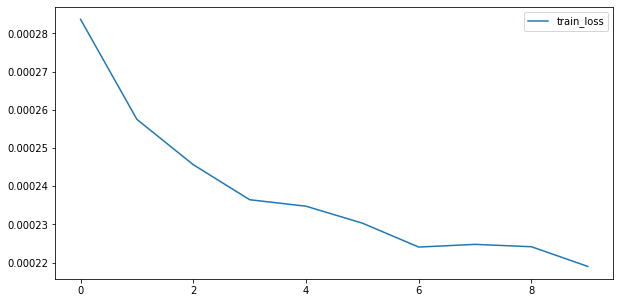

In [50]:
### 根据train_loss_list绘制损失值曲线
plt.figure(figsize=(10,5))
plt.plot(train_loss_list,label='train_loss')
plt.legend()
plt.show()

In [39]:
### 测试集，测试模型性能
### 读入模型
model.load_state_dict(torch.load('best_model.pth'))

### 遍历测试集，计算准确率 召回率 F1值

y_true = []
y_pred = []


loss_list = []
acc_list = []
call_list = []
F1_list = []

best_acc = 0
best_loss = 1e10
best_call = 0
best_F1 = 0
best_loss = 1e10


model.eval()
val_loader = DataLoader(dataset=val_dataset,batch_size=512,shuffle=False)
for step,(batch_x,batch_y) in enumerate(val_loader):
    batch_x = Variable(batch_x)
    batch_y = Variable(batch_y)
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)
    outputs = model(batch_x)
    outputs = outputs.squeeze(1)
    
    outputs = torch.sigmoid(outputs)
    loss = loss_func(outputs,batch_y)

    pred = (outputs > 0.5)
    y_true.extend(batch_y.data.cpu().numpy().tolist())
    y_pred.extend(pred.cpu().numpy().tolist())

    ### 使用sklearn计算召回率
    call_value = recall_score(batch_y.data.cpu().numpy().tolist(),pred.cpu().numpy().tolist(),average='macro')
    f1_score_value = f1_score(batch_y.data.cpu().numpy(),pred.cpu().numpy(),average='macro')
    acc_value = accuracy_score(batch_y.data.cpu().numpy(),pred.cpu().numpy())


    ### 使用sklearn中的metrics中的函数计算准确率 召回率 F1值
    loss_list.append(loss.data.item())
    call_list.append(call_value)
    F1_list.append(f1_score_value)
    acc_list.append(acc_value)



    if acc_value > best_acc:
        best_acc = acc_value
    
    if f1_score_value > best_F1:
        best_F1 = f1_score_value
    
    if loss.data.item() < best_loss:
        best_loss = loss.data.item()
    
    if call_value > best_call:
        best_call = call_value


    del batch_x,batch_y,outputs,loss,pred
    torch.cuda.empty_cache()


In [46]:
print('recall:{}，F1:{}，loss：{},acc:{}'.format(best_call,best_F1,best_loss,best_acc))

recall:0.9435285677214513，F1:0.9433539728138747，loss：0.1754274070262909,acc:0.943359375


In [47]:
### 导入绘制roc曲线的库
from sklearn.metrics import roc_curve,auc
### 导入plt
import matplotlib.pyplot as plt

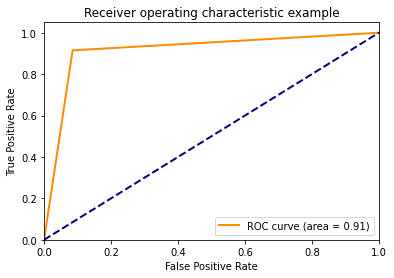

In [48]:
### 利用y_true和y_pred绘制ROC曲线
fpr,tpr,thresholds = roc_curve(y_true,y_pred)
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2
plt.plot(fpr,tpr,color='darkorange',lw=lw,label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1],color='navy',lw=lw,linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()



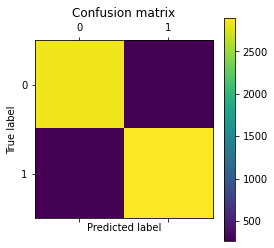

In [49]:
### 绘制混淆矩阵
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true,y_pred)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
